## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


#### Looks fine, no clearly abnormal data in first sight...

b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


#### There are 294478 rows in the dataset.

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

#### There are 290584 unique users in the dataset, i.e. 3894 users make more than 1 entries.

d. The proportion of users converted.

In [5]:
df.query('converted == 1').nunique()

user_id         35173
timestamp       35237
group               2
landing_page        2
converted           1
dtype: int64

In [6]:
35173/290584

0.12104245244060237

#### The proportion of user converted is only 12%, not as good as expected.

e. The number of times the `new_page` and `treatment` don't match.

In [7]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

#### There are 3893 incidents where "new_page" and "treatment" not match, which doesn't make sense.
- Consider consult the data preparer for reason of this deviation or drop the data.

f. Do any of the rows have missing values?

In [8]:
df.isnull().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

#### Great, we don't have null values.

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
df2 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == True]

In [10]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [12]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

#### There are 290584 unique ids in df2.

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
df2[df2['user_id'].duplicated() == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


#### hmm... user id 773192 repeats twice! We don't like this...

c. What is the row information for the repeat **user_id**? 

In [14]:
df2[df2['user_id'].duplicated() == True].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 2893 to 2893
Data columns (total 5 columns):
user_id         1 non-null int64
timestamp       1 non-null object
group           1 non-null object
landing_page    1 non-null object
converted       1 non-null int64
dtypes: int64(2), object(3)
memory usage: 48.0+ bytes


#### The duplicated user is is in row 2893

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


#### Seems like we'd need to remove one of those above.

In [16]:
df2 = df2.drop_duplicates(subset = ['user_id'], keep='first')

#### Check our results

In [17]:
df2.duplicated().any()

False

#### Yeah! Good to go.

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [18]:
df2[df2['converted']== 1].count()/df2['converted'].count()

user_id         0.119597
timestamp       0.119597
group           0.119597
landing_page    0.119597
converted       0.119597
dtype: float64

#### Overall, there's a probability of 11.96% for conversion regardless of page they receive. 

b. Given that an individual was in the `control` group, what is the probability they converted?

In [19]:
df2[(df2['converted']==1) & (df2['group'] =='control')].count()/df2[df2['group'] == 'control'].count()

user_id         0.120386
timestamp       0.120386
group           0.120386
landing_page    0.120386
converted       0.120386
dtype: float64

#### Conversion probability for control group is 12.04%

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [20]:
df2[(df2['converted']==1) & (df2['group'] =='treatment')].count()/df2[df2['group'] == 'treatment'].count()

user_id         0.118808
timestamp       0.118808
group           0.118808
landing_page    0.118808
converted       0.118808
dtype: float64

#### Conversion probability for treatment group is 11.88%

d. What is the probability that an individual received the new page?

In [21]:
df2[df2['landing_page'] == 'new_page'].count()/df2['landing_page'].count()

user_id         0.500062
timestamp       0.500062
group           0.500062
landing_page    0.500062
converted       0.500062
dtype: float64

#### The probability that an individual received the new page is 50.01%

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Based on results from step a-d, the conversion probability of the control group and the treatment group seem quite close, around the same level as teh overall conversion probability. Given that around 1/2 of the individuals actually received the new page, this result may reveal that making a new page dooesn't contribute much to increase conversion rate. But this is not clearly, easily observed.**

**Also we got another variable, timestamp here, their may be some endgeneity issue.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**H0: $p_{new}$ <= $p_{old}$**

**H1: $p_{new}$ > $p_{old}$**


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [22]:
df2[df2['converted']== 1].count()/df2['converted'].count()

user_id         0.119597
timestamp       0.119597
group           0.119597
landing_page    0.119597
converted       0.119597
dtype: float64

#### Conversion rate for $p_{new}$ under the null is 11.96%

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

#### Under the null hypothesis, $p_{new}$ = $p_{old}$ = 11.96%

c. What is $n_{new}$, the number of individuals in the treatment group?

In [23]:
df2[df2['group'] == 'treatment'].count()

user_id         145310
timestamp       145310
group           145310
landing_page    145310
converted       145310
dtype: int64

#### $n_{new}$ = 145310

d. What is $n_{old}$, the number of individuals in the control group?

In [24]:
df2[df2['group'] == 'control'].count()

user_id         145274
timestamp       145274
group           145274
landing_page    145274
converted       145274
dtype: int64

#### $n_{old}$ = 145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
import numpy as np

In [26]:
p_new = df2['converted'].mean()
n_new = len(df2[df2['group'] == 'treatment'])
new_page_converted = np.random.choice([0,1], size=n_new, p=[(1-p_new) ,p_new])
new_page_converted

array([1, 0, 1, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [27]:
p_old = df2['converted'].mean()
n_old = len(df2[df2['group'] == 'control'])
old_page_converted = np.random.choice([0,1], size=n_old, p=[(1-p_old) ,p_old])
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [28]:
p_new - p_old

0.0

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [29]:
p_diffs = []
for _ in range(10000):
    diff = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(diff)

In [30]:
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

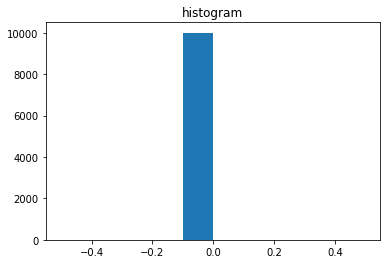

In [35]:
plt.hist(p_diffs) 
plt.title("histogram") 
plt.show()

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [37]:
obs_diff = df2['converted'][df2['group'] == 'treatment'].mean() - df2['converted'][df2['group'] == 'control'].mean()

In [38]:
(p_diffs>obs_diff).mean()

1.0

#### All p_diffs are greater than the actual difference observed in ab_data.csv (which is 0)

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

#### This is p-value, basically the margin of error that can be tolerated in the hypothesis testing. Given that the proportion is 1, which is much higher tha the 0.05 (signifying 95% confidence), the alternative hypothesis is not of statistical significance, meaning we do not have enough evidence to reject the null hypothesis.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [55]:
import statsmodels.api as sm

convert_old = sum((df2.group == 'control') & (df2.converted == 1))
convert_new = sum((df2.group == 'treatment') & (df2.converted == 1))
n_old = sum(df2.group == 'control')
n_new = sum(df2.group == 'treatment')

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [56]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')

In [57]:
z_score

-1.3109241984234394

In [58]:
p_value

0.90505831275902449

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

#### The z-score and p-value above confirm the findings in part j and k, basically no statistical significance to prove that convertion rates of the old and new pages are different.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [59]:
df2['intercept'] = 1
df2['ab_page'] = (df2.group == 'treatment').astype(int)

c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [60]:
model = sm.Logit(df2.converted, df2[['intercept', 'ab_page']])

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [62]:
result = model.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-11-21 09:41 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

#### The p-value is 0.1899. This figure differs from the p-value in Part II as the underlying hypotheses are different.

#### In Part II, the hypotheses are:
**H0: $p_{new}$ <= $p_{old}$**

**H1: $p_{new}$ > $p_{old}$**

#### In Part III, the hypotheses are:

**H0: $p_{new}$ = $p_{old}$**

**H1: $p_{new}$ != $p_{old}$**


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

#### The lack statistical significance of our current hypotheses is an implication of other potential relationships. Considering more factors into the model to form a multiple regression may be valuable in this regard. However adding to many factors in a model may give an impression of factor hacking and may result in biases or lack of economic significance.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

#### Import country data

In [63]:
df3 = pd.read_csv('countries.csv')

In [70]:
df3

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK
5,909908,UK
6,811617,US
7,938122,US
8,887018,US
9,820683,US


#### Join two dataframes into one merged dataframe

In [71]:
df4 = df2.join(df3.set_index('user_id'), on='user_id')

In [72]:
df4.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


#### Multivariate logistic regression

In [76]:
df4['intercept'] = 1
df4['ab_page'] = (df4.group == 'treatment').astype(int)
df4['UK'] = (df4.country == 'UK').astype(int)
df4['CA'] = (df4.country == 'CA').astype(int)

In [77]:
model = sm.Logit(df4['converted'], df4[['intercept', 'CA', 'UK']])
results = model.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-11-21 10:11 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
CA           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
UK            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
==================================================================

"""

#### Seems that countries do not have an impact on conversion rates.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [78]:
df4['ab_page_UK'] = df4['ab_page']*df4['UK'] 
df4['ab_page_CA'] = df4['ab_page']*df4['CA']

In [79]:
model = sm.Logit(df4['converted'], df4[['intercept', 'ab_page_CA', 'ab_page_UK']])
results = model.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-11-21 10:16 AIC:              212779.0384
No. Observations:   290584           BIC:              212810.7773
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9963    0.0062  -322.0487  0.0000  -2.0084  -1.9841
ab_page_CA   -0.0752    0.0376    -1.9974  0.0458  -0.1489  -0.0014
ab_page_UK    0.0149    0.0173     0.8617  0.3888  -0.0190   0.0488
==================================================================

"""

#### Cool, p_value demonstrates statistical significance. A composite of page and country factor actually show a good prediction of conversion rates. US and CA users are more unlikely to convert given the new page while UK users are more likely to convert given the new page.

#### But hold on...practically the above insights may not readily bring economic value based on the following reasons. 1) It may be impractical to only deliver new page to UK users but keep thinds old for US and CA users as a long-term business practice. 2) The impact of country is statistical weak given the coefficients, meaning it may just be overly expensive to leverage the insights.

#### Final suggestion is to keep the old page.

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [39]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0